<a href="https://colab.research.google.com/github/rohaan2614/var_from_scratch/blob/master/var_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
!rm -r sample_data

In [ ]:
import numpy as np
import gzip
from urllib import request
from tqdm import tqdm
import os

In [ ]:
# Constants
url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

In [ ]:
# Create the "data" directory if it doesn't exist
os.makedirs("data", exist_ok=True)

In [ ]:
# Download the dataset
for filename in tqdm(filenames, desc="Downloading Dataset"):
    request.urlretrieve(url + filename, os.path.join("data", filename))

In [ ]:
# Read dataset
data = []
for filename in os.listdir("data"):
    filepath = os.path.join("data", filename)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            # Load the labels as a one-dimensional array of integers
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # Load the images as a two-dimensional array of pixels
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28))

In [ ]:
print("Data Length: ", len(data), "\ndata: ", data)

Data Length:  4 
data:  [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)]


# AutoEncoder Class

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Optional

class AutoEncoder(nn.Module):
    def __init__(self,
                 number_hidden_units : int,
                 encoder : nn.Sequential,
                 decoder : nn.Sequential,
                 train_loader: Optional[DataLoader] = None):
        super().__init__()
        self.num_hidden = number_hidden_units
        self.encoder = encoder
        self.decoder = decoder
        self.train_loader = train_loader

    def set_train_loader(self, train_loader: DataLoader):
        self.train_loader = train_loader

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def describe(self) -> None:
        description = (
            f"AutoEncoder Model\n"
            f"=================\n"
            f"Number of Hidden Units: {self.num_hidden}\n"
            f"Encoder:\n"
            f"{self._describe_sequential(self.encoder)}\n"
            f"Decoder:\n"
            f"{self._describe_sequential(self.decoder)}\n"
        )
        if self.train_loader is not None:
            description += f"Train Loader:\n{self._describe_loader(self.train_loader)}\n"
        print(description)

    def _describe_sequential(self, sequential) -> str:
        layer_descriptions = []
        for i, layer in enumerate(sequential):
            layer_descriptions.append(f"  Layer {i + 1}: {self._describe_layer(layer)}")
        return "\n".join(layer_descriptions)

    def _describe_layer(self, layer) -> str:
        if isinstance(layer, nn.Linear):
            return f"{layer.__class__.__name__} - Input Features: {layer.in_features}, Output Features: {layer.out_features}"
        else:
            return f"{layer.__class__.__name__}"

    def _describe_loader(self, loader: DataLoader) -> str:
        dataset_name = loader.dataset.__class__.__name__
        num_samples = len(loader.dataset)
        num_batches = len(loader)
        return f"  Dataset: {dataset_name}\n  Number of Samples: {num_samples}\n  Number of Batches: {num_batches}"

In [ ]:
test_encoder = nn.Sequential(
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU())

test_decoder = nn.Sequential(
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.Sigmoid())

# Create AutoEncoder instance
autoencoder = AutoEncoder(number_hidden_units=4, encoder=test_encoder, decoder=test_decoder)

# Describe the model
autoencoder.describe()

AutoEncoder Model
Number of Hidden Units: 4
Encoder:
  Layer 1: Linear - Input Features: 16, Output Features: 8
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 8, Output Features: 4
  Layer 4: ReLU
Decoder:
  Layer 1: Linear - Input Features: 4, Output Features: 8
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 8, Output Features: 16
  Layer 4: Sigmoid



# Data Transformation

In [ ]:
# Split into training and testing sets
X_train, y_train, X_test, y_test = data

In [ ]:
print("X_Train: ", X_train)
print("X_Test: ", X_test)

X_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X_Test:  [7 2 1 ... 4 5 6]


In [ ]:
# Normalize the pixel values
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [ ]:
print("X_Train: ", X_train)
print("X_Test: ", X_test)

X_Train:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_Test:  [0.02745098 0.00784314 0.00392157 ... 0.01568628 0.01960784 0.02352941]


In [ ]:
print("y_Train: ", y_train)
print("y_Test: ", y_test)

y_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_Test:  [5 0 4 ... 5 6 8]


In [ ]:
# Convert labels to integers
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [ ]:
print("y_Train: ", y_train)
print("y_Test: ", y_test)

y_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_Test:  [5 0 4 ... 5 6 8]


In [ ]:
# Convert the training data to PyTorch tensors
import torch
X_train = torch.from_numpy(X_train)

In [ ]:
# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=64, shuffle=True
)

In [ ]:
encoder = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 8),
        nn.ReLU())

decoder = nn.Sequential(
        nn.Linear(8, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid())

# Create AutoEncoder instance
autoencoder = AutoEncoder(number_hidden_units=8,
                          encoder=encoder,
                          decoder=decoder,
                          train_loader=train_loader)
# Describe the model
autoencoder.describe()

AutoEncoder Model
Number of Hidden Units: 8
Encoder:
  Layer 1: Linear - Input Features: 784, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 8
  Layer 4: ReLU
Decoder:
  Layer 1: Linear - Input Features: 8, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 784
  Layer 4: Sigmoid
Train Loader:
  Dataset: Tensor
  Number of Samples: 10000
  Number of Batches: 157



In [ ]:
import torch.optim as optim

num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=batch_size, shuffle=True
)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device
        data = data.to(device)

        # Forward pass
        encoded, decoded = autoencoder(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/10: loss=0.0289
Epoch 2/10: loss=0.0287
Epoch 3/10: loss=0.0284
Epoch 4/10: loss=0.0281
Epoch 5/10: loss=0.0279
Epoch 6/10: loss=0.0277
Epoch 7/10: loss=0.0276
Epoch 8/10: loss=0.0274
Epoch 9/10: loss=0.0272
Epoch 10/10: loss=0.0271


# Visualize

### Reconstructed

In [ ]:
# Move tensor to CPU and convert to numpy array
reconstructed_images = decoded.cpu().detach().numpy()
len(reconstructed_images)

16

In [ ]:
# Reshape the pixel values into images
num_channels = 1
height = 28
width = 28
reconstructed_images = reconstructed_images.reshape(len(reconstructed_images), num_channels, height, width)
len(reconstructed_images), reconstructed_images.shape

(16, (16, 1, 28, 28))

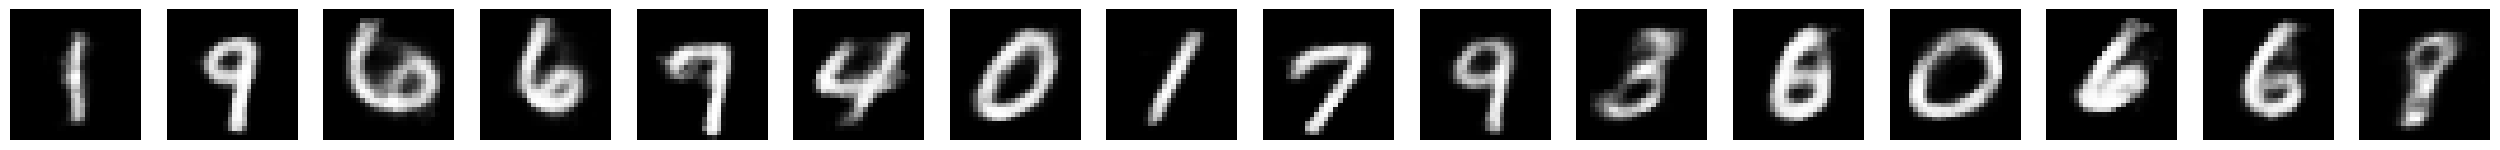

In [ ]:
import matplotlib.pyplot as plt

# Plot the reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=len(reconstructed_images), figsize=(len(reconstructed_images) * 2, 2))
for i in range(len(reconstructed_images)):
    if num_channels == 1:
        axes[i].imshow(reconstructed_images[i][0], cmap='gray')
    else:
        axes[i].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
    axes[i].axis('off')
plt.show()

### Original vs Reconstructed

In [ ]:
# Move tensor to CPU and convert to numpy array
original_images = data.cpu().detach().numpy()
len(original_images)

16

In [ ]:
# Reshape the pixel values into images
original_images = original_images.reshape(len(original_images), num_channels, height, width)
len(original_images), original_images.shape

(16, (16, 1, 28, 28))

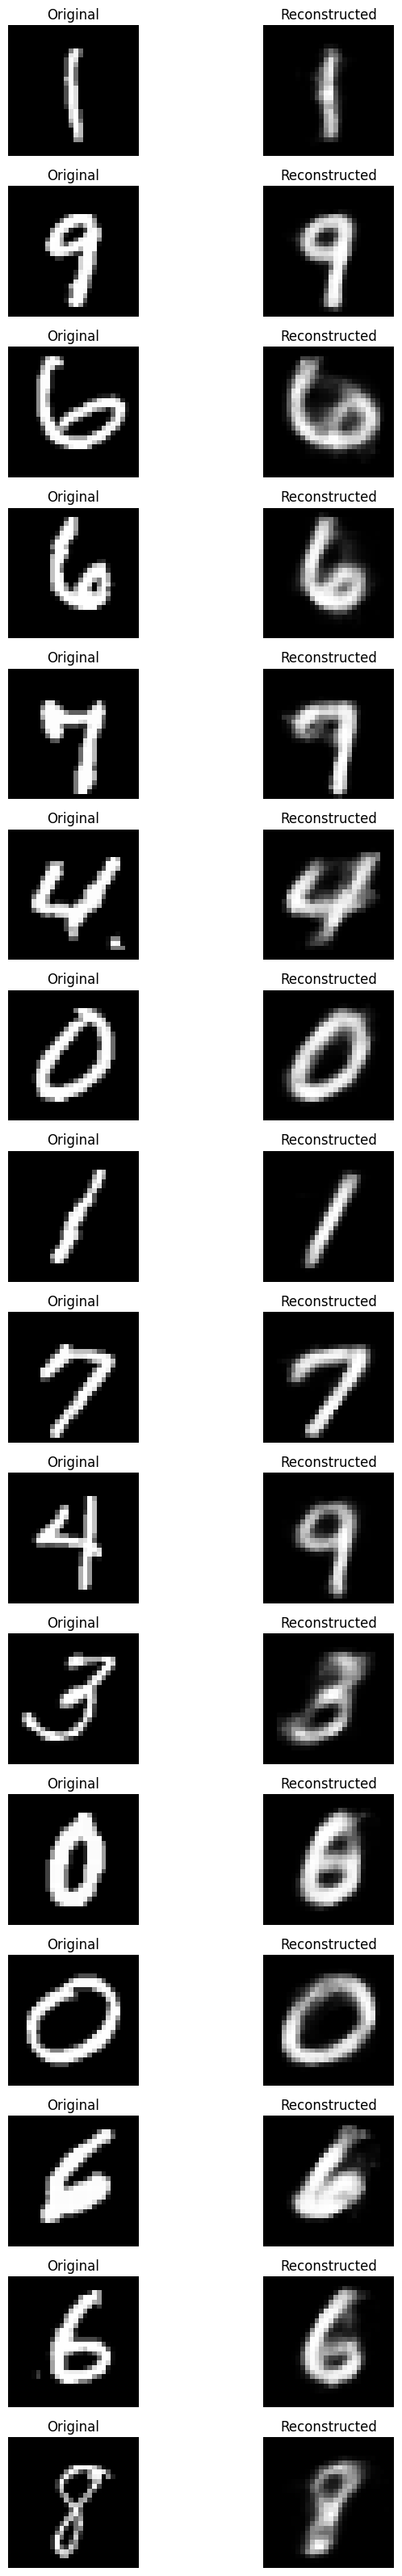

In [ ]:
fig, axes = plt.subplots(nrows=len(original_images), ncols=2, figsize=(8, len(original_images) * 2))
for i in range(len(original_images)):
    # Plot original image
    if num_channels == 1:
        axes[i, 0].imshow(original_images[i][0], cmap='gray')
    else:
        axes[i, 0].imshow(np.transpose(original_images[i], (1, 2, 0)))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Plot reconstructed image
    if num_channels == 1:
        axes[i, 1].imshow(reconstructed_images[i][0], cmap='gray')
    else:
        axes[i, 1].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()